# Specific Dynamic Feature improving the performance of a model

## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'\src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *

# import scikit-learn
from sklearn.linear_model import LinearRegression
# tree models and support vector machines
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import pearson correlation
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from copy import deepcopy

## Notebook Parameters

In [4]:
import os 

### parameters 

notebook_name = 'exp3_drug_model' # name of the notebook

## Generation of ground truth model 

model_name = 'v3_medium_model_15_10'
o_random_seed = 9
p_random_seed = 7
no_observable_species = 15
no_feedback_regulations = 10
specie_value_range = (5, 5000)
param_range = (0.1, 10)
param_multiplier_range = (0.5, 1.5)


## Simulation parameters 

simulation_time = 500 
simulation_step = 100

## Feature data generation 

feature_generation_method = 'uniform'
feature_generation_extra_params = {'min': 0.1, 'max': 10}
feature_generation_size = 1000 
feature_generation_seed = 50 # if -1 then 'o_random_seed' is used
if feature_generation_seed == -1:
    feature_generation_seed = o_random_seed
    
## Data engineering parameters

# Suboptimal Model Generation 

'''
Options: 
- 'feedback_prune': removes feedback regulations from the model 
- 'random parameter': randomizes a x% of parameter values of the model
'''

# Engineering Feature Data 

data_engineering_method = 'dynamic_feature'
''' 
Options: 
- 'last_time_point' : only the last time point of the phosphorylated species is used
- 'dynamic_feature': computes the characteristic 'ten' dynamic feature for each specie data 
'''

## General parameters
parallelise = True
save_figures = True 
experiment_id = notebook_name + '_' + str(o_random_seed) + '_' + str(feature_generation_seed)
experiment_folder = config['DATA_PATH'] + '/' + experiment_id + '/'
if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)
    
print(experiment_folder)

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp3_drug_model_9_50/


## Analysis

### Virtual Cell Creation

In [5]:
# create a drug enabled model 
from models.Utils import *
from models.DrugModelSpecification import DrugModelSpecification, Drug

model_drug_spec = DrugModelSpecification()
model_drug_spec.generate_specifications(o_random_seed, no_observable_species, no_feedback_regulations, verbose=0)
drug_0 = Drug('D0', 500, 5000)
np.random.seed(o_random_seed)
# add random 'up' and 'down' regulations to the drug
regulation_dir = []
for i, s in enumerate(model_drug_spec.A_species):
    regulation_dir.append(np.random.choice(['up', 'down']))
    drug_0.add_regulation(s, 'up')
model_drug_spec.add_drug(drug_0)
print(model_drug_spec)
print(f'Feedback: {model_drug_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14']
C Species: ['C']
Regulations: [('B14', 'B13'), ('B5', 'B7'), ('B11', 'B7'), ('B1', 'B7'), ('B11', 'A8'), ('B1', 'B9'), ('B11', 'A1'), ('B12', 'A0'), ('B14', 'B12'), ('B10', 'B9'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('A5', 'B5'), ('A6', 'B6'), ('A7', 'B7'), ('A8', 'B8'), ('A9', 'B9'), ('A10', 'B10'), ('A11', 'B11'), ('A12', 'B12'), ('A13', 'B13'), ('A14', 'B14'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B3', 'C'), ('B4', 'C'), ('B5', 'C'), ('B6', 'C'), ('B7', 'C'), ('B8', 'C'), ('B9', 'C'), ('B10', 'C'), ('B11', 'C'), ('B12', 'C'), ('B13', 'C'), ('B0', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2'), ('D0', 'A3'), ('D0', 'A4'), ('D0', 'A5'), ('D0', 'A6'), ('D0', 'A7'), ('D0', 'A8'), ('D0', 'A9'), ('D0', 'A10'), ('D0', 'A11'), ('D0', 'A12'), ('

In [6]:
G0_d = model_drug_spec.generate_network('drug_model_524', specie_value_range, param_range, param_multiplier_range, random_seed=5, verbose=0)
base_parameters = G0_d.get_parameters()
base_initial_conditions = G0_d.get_state_variables()

In [7]:
print(G0_d.get_antimony_model())

model drug_model_524

J0: A0p -> A0; J0_Vmax*A0p/(J0_Km + A0p)
J1: A0 -> A0p; (J1_Vmax+B12p*J1_Kw0+D0*J1_Kw1)*A0/(J1_Km + A0)
J2: A1p -> A1; J2_Vmax*A1p/(J2_Km + A1p)
J3: A1 -> A1p; (J3_Vmax+D0*J3_Kw0)*A1/(J3_Km*(1+B11p*J3_Kic0) + A1)
J4: A2p -> A2; J4_Vmax*A2p/(J4_Km + A2p)
J5: A2 -> A2p; (J5_Vmax+D0*J5_Kw0)*A2/(J5_Km + A2)
J6: A3p -> A3; J6_Vmax*A3p/(J6_Km + A3p)
J7: A3 -> A3p; (J7_Vmax+D0*J7_Kw0)*A3/(J7_Km + A3)
J8: A4p -> A4; J8_Vmax*A4p/(J8_Km + A4p)
J9: A4 -> A4p; (J9_Vmax+D0*J9_Kw0)*A4/(J9_Km + A4)
J10: A5p -> A5; J10_Vmax*A5p/(J10_Km + A5p)
J11: A5 -> A5p; (J11_Vmax+D0*J11_Kw0)*A5/(J11_Km + A5)
J12: A6p -> A6; J12_Vmax*A6p/(J12_Km + A6p)
J13: A6 -> A6p; (J13_Vmax+D0*J13_Kw0)*A6/(J13_Km + A6)
J14: A7p -> A7; J14_Vmax*A7p/(J14_Km + A7p)
J15: A7 -> A7p; (J15_Vmax+D0*J15_Kw0)*A7/(J15_Km + A7)
J16: A8p -> A8; J16_Vmax*A8p/(J16_Km + A8p)
J17: A8 -> A8p; (J17_Vmax+B11p*J17_Kw0+D0*J17_Kw1)*A8/(J17_Km + A8)
J18: A9p -> A9; J18_Vmax*A9p/(J18_Km + A9p)
J19: A9 -> A9p; (J19_Vmax+D0*J19_Kw0

In [8]:
# test simulation 

from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(G0_d.get_sbml_model())

result = solver.simulate(0, 1000, 100)
result

,time,A0p,A0,B12p,A1p,A1,B11p,A2p,A2,A3p,...,B10p,B10,B11,B12,B14p,B13p,B13,B14,C,Cp
0,0.00000,0.000000,1037.000000,0.000000,0.000000,2199.000000,0.000000,0.000000,4425.000000,0.000000,...,0.000000,593.000000,3835.000000,1099.000000,0.000000,0.000000,1798.000000,3607.000000,100.000000,0.000000
1,10.10101,976.585387,60.414613,238.450322,34.130902,2164.869098,21.990348,5.779276,4419.220724,24.835594,...,58.362989,534.637011,3813.009652,860.549678,70.156853,158.332075,1639.667925,3536.843147,70.098809,29.901191
2,20.20202,1034.001844,2.998156,551.918166,56.123479,2142.876521,25.759938,5.779296,4419.220704,27.078871,...,105.768335,487.231665,3809.240062,547.081834,103.279010,416.529252,1381.470748,3503.720990,72.719764,27.280236
3,30.30303,1034.963080,2.036920,801.251081,72.475066,2126.524934,28.849891,5.779296,4419.220704,27.292332,...,143.484788,449.515212,3806.150109,297.748919,116.417641,649.152525,1148.847475,3490.582359,73.690397,26.309603
4,40.40404,1035.259588,1.740412,933.817537,84.713798,2114.286202,31.815183,5.779296,4419.220704,27.312738,...,173.020550,419.979450,3803.184817,165.182463,121.041569,826.792136,971.207864,3485.958431,72.822718,27.177282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,959.59596,1036.637174,0.362826,1096.912938,1035.462663,1163.537337,2781.814056,4382.701570,42.298430,3970.286145,...,590.853958,2.146042,1053.185944,2.087062,3596.532411,1789.064452,8.935548,10.467589,45.197591,54.802409
96,969.69697,1036.637174,0.362826,1096.912938,1031.498690,1167.501310,2782.104573,4382.701570,42.298430,3970.286145,...,590.853958,2.146042,1052.895427,2.087062,3596.532411,1789.064452,8.935548,10.467589,45.197702,54.802298
97,979.79798,1036.637174,0.362826,1096.912938,1027.786398,1171.213602,2782.344909,4382.701570,42.298430,3970.286145,...,590.853958,2.146042,1052.655091,2.087062,3596.532411,1789.064452,8.935548,10.467589,45.197826,54.802174
98,989.89899,1036.637174,0.362826,1096.912938,1024.310669,1174.689331,2782.543722,4382.701570,42.298430,3970.286145,...,590.853958,2.146042,1052.456278,2.087062,3596.532411,1789.064452,8.935548,10.467589,45.197960,54.802040


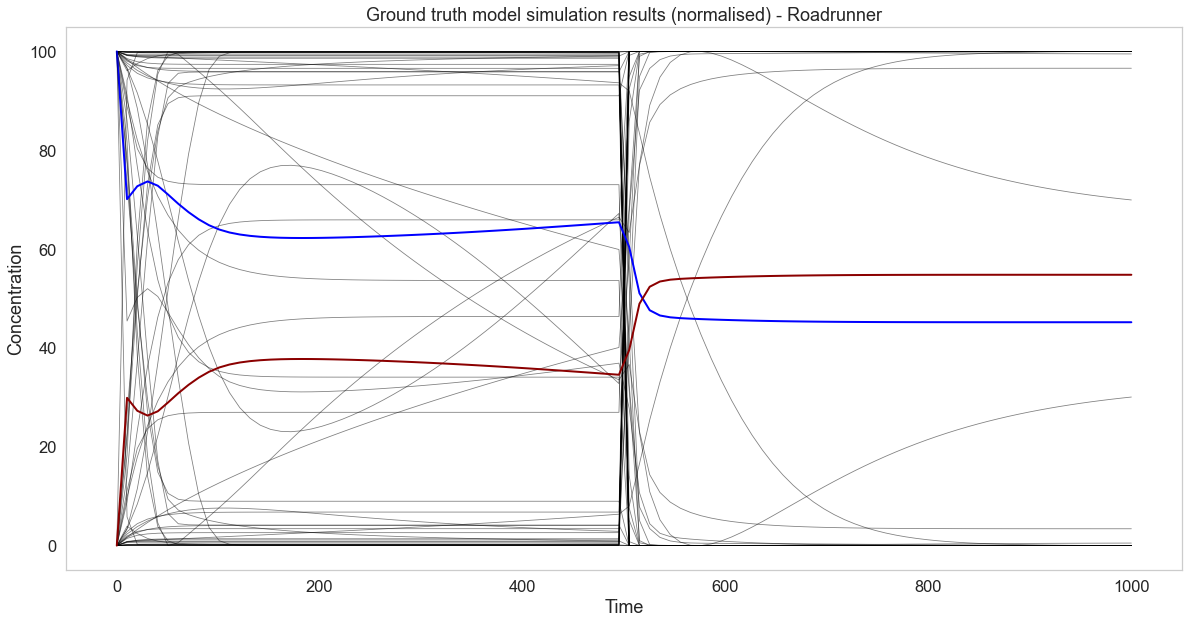

In [9]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Ground truth model simulation results (normalised) - Roadrunner')
plt.grid()
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
legend = plt.gca().get_legend()
if legend:
    legend.remove()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Generate synthetic 'omics-like' data

In [ ]:
from models.SyntheticGen import generate_feature_data, generate_target_data

feature_data = generate_feature_data(model_drug_spec, G0_d.get_state_variables(), feature_generation_method, feature_generation_extra_params, 1000, feature_generation_seed)
target_data, _ = generate_target_data(model_drug_spec, solver, feature_data, {'start': 0, 'end': 1000, 'points': 100})


KeyboardInterrupt: 

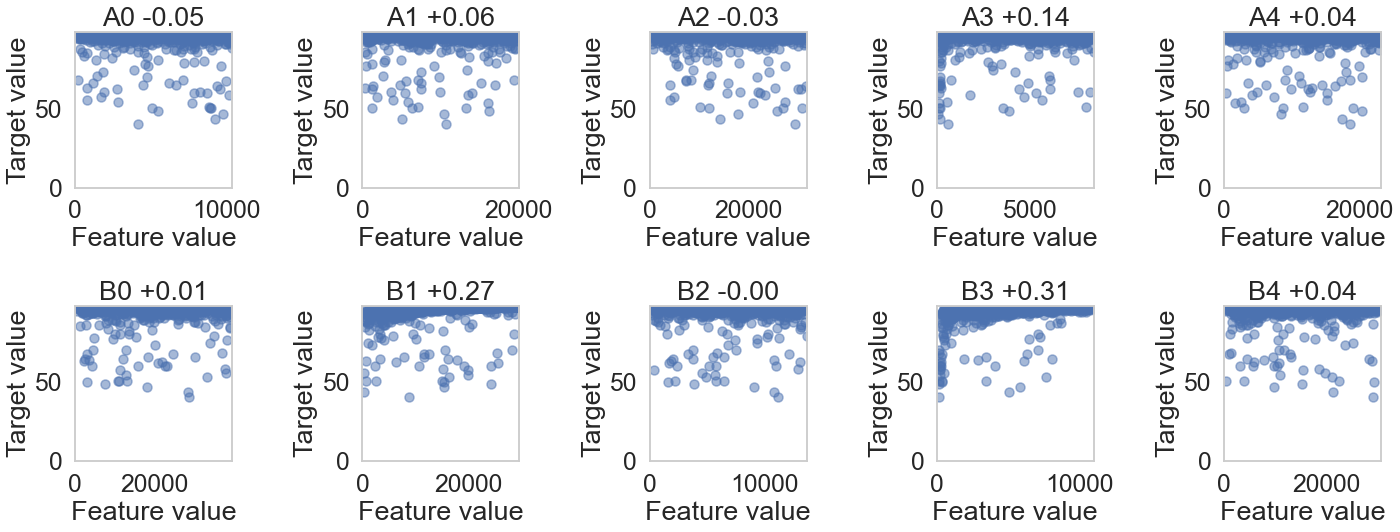

In [ ]:
# plot association between the features and the target data 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for each feature, plot the association with the target data, which is only a series 
# plot all features in separate subplots
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.5) 

# make a subplot based on the size of feature_data, have five columns and as many rows as needed
n_features = len(feature_data.columns)
n_rows = int(n_features / 5) 
n_cols = 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
axs = axs.flatten()
# plot each feature in a separate subplot
for i, feature in enumerate(feature_data.columns):
    # plot the feature data and target data
    corr, _ = pearsonr(feature_data[feature], target_data)
    axs[i].scatter(feature_data[feature], target_data, alpha=0.5)
    corr_str = str(corr)
    # polish the correlation string to 2 decimal places, remove [ 
    # and ] and add a + sign if the correlation is positive
    if corr > 0:
        corr_str = '+' + corr_str[1:5]
    else:
        corr_str = corr_str[1:6]
        
    axs[i].set_title(f'{feature} {corr_str}')
    axs[i].set_xlabel('Feature value')
    axs[i].set_ylabel('Target value')
    axs[i].grid()
    # set the x and y limits to be the same for all subplots
    max_feature = feature_data[feature].values.max()   
    max_target = target_data.values.max()  
    axs[i].set_xlim([0,max_feature])
    axs[i].set_ylim([0,max_target])
    # compute the correlation between the feature and target data
plt.tight_layout()
plt.show()

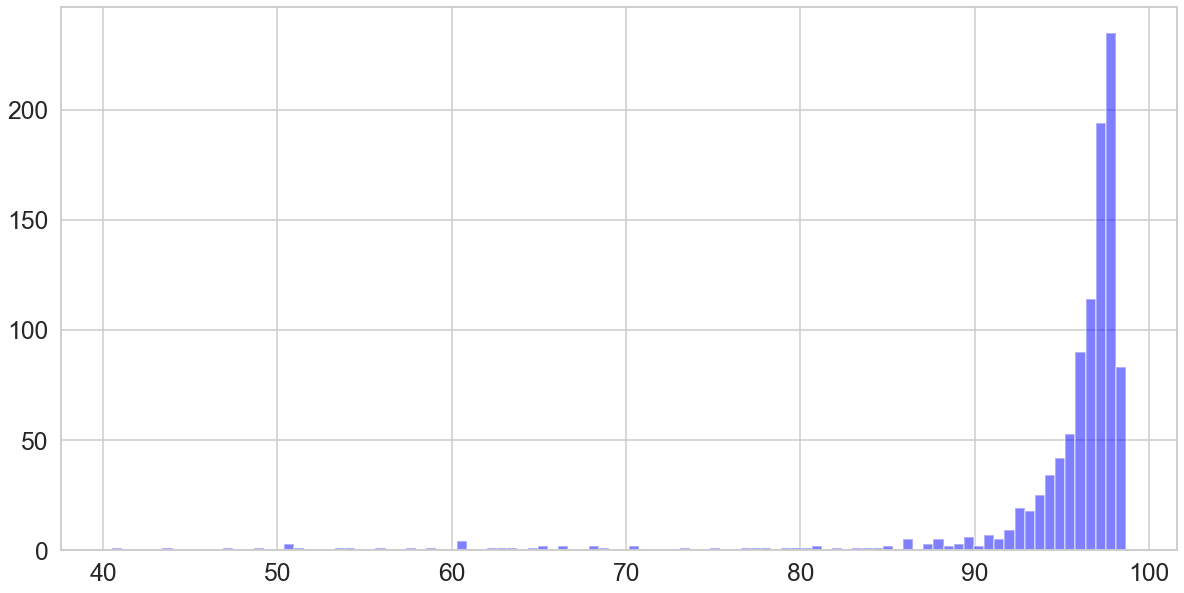

In [ ]:
# plot the target data only with the x axis being 0 to 100 
plt.figure(figsize=(20, 10))
plt.hist(target_data, bins=100, alpha=0.5, color='blue')
plt.show()

### Suboptimal Model Creation

#### If modifying at the model architectural level

Mostly done to modify the `ModelSpec` object, where the updated spec information is transferred to a new `ModelBuilder` object, which then need to transpile to Antimony/SBML for a Solver instance. 

NewSpec --> NewBuilder --> Update parameters to original builder --> Transpile to Antimony/SBML --> Solver instance

#### If only changes to states and parameters are needed

Simply duplicate the `ModelBuilder` object and update the states and parameters.
```


In [ ]:
# randomise links and parameters by using a different random seed

new_spec = DrugModelSpecification()
new_spec.generate_specifications(6, 5, 2, verbose=0)
drug_0 = Drug('D0', 500, 5000)
drug_0.add_regulation('A0', 'down')
drug_0.add_regulation('A1', 'down')
drug_0.add_regulation('A2', 'down')
new_spec.add_drug(drug_0)
print(new_spec)
print(f'Feedback: {new_spec.get_feedback_regulations()}')

A Species: ['A0', 'A1', 'A2', 'A3', 'A4']
B Species: ['B0', 'B1', 'B2', 'B3', 'B4']
C Species: ['C']
Regulations: [('B2', 'B4'), ('B0', 'B4'), ('A0', 'B0'), ('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3'), ('A4', 'B4'), ('B0', 'C'), ('B1', 'C'), ('B2', 'C'), ('B0', 'C'), ('B1', 'C'), ('D0', 'A0'), ('D0', 'A1'), ('D0', 'A2')]
Regulation Types: ['down', 'down', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'up', 'down', 'down', 'down', 'down', 'down']
Drugs:
Drug(D0, 500, ['A0', 'A1', 'A2'], ['down', 'down', 'down'])

Feedback: [(('B2', 'B4'), 'down'), (('B0', 'B4'), 'down')]


In [ ]:
new_model = new_spec.generate_network('drug_model_552', specie_value_range, param_range, param_multiplier_range, random_seed=6, verbose=0)
new_base_parameters = new_model.get_parameters()
new_base_initial_conditions = new_model.get_state_variables()

In [ ]:
new_solver = RoadrunnerSolver()
new_solver.compile(new_model.get_sbml_model())
new_result = new_solver.simulate(0, 1000, 100)

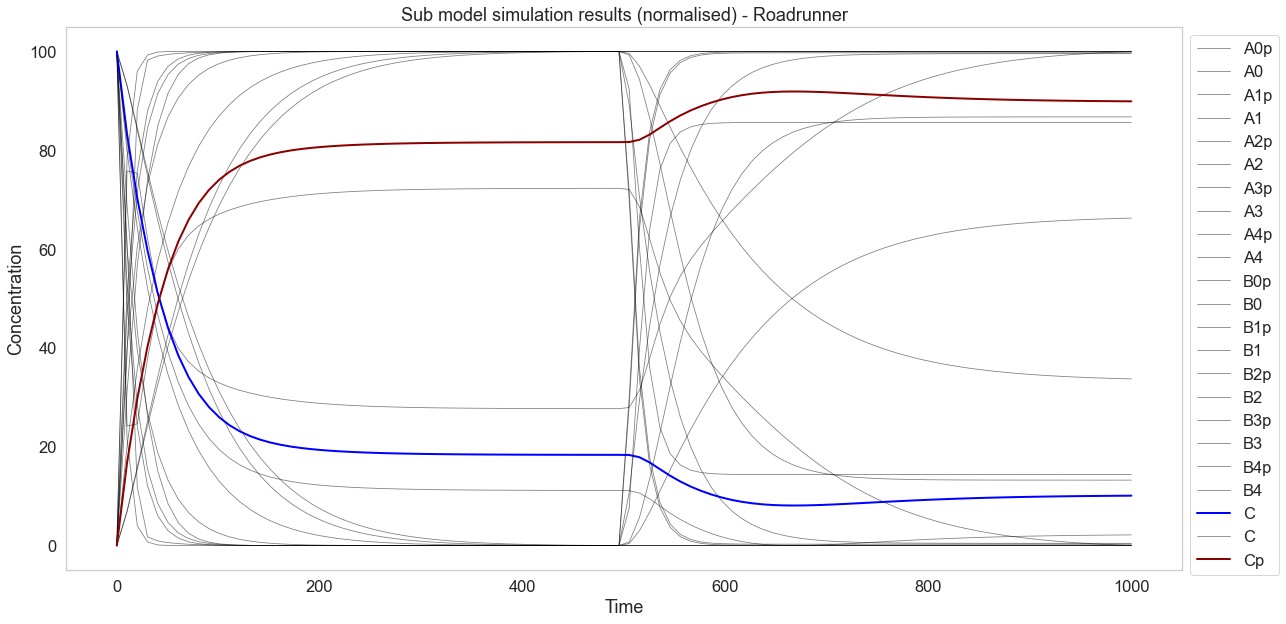

In [ ]:
# use pandas default plot to plot the simulation results
import matplotlib.pyplot as plt
import seaborn as sns

states_variable_names = G0_d.get_state_variables()
result = new_result

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Plot the simulation results
plt.figure(figsize=(20, 10))

for state in states_variable_names:
    if state == 'C':
        plt.plot(result['time'], result[state], label=state, c='blue', linewidth=2)
    if state == 'Cp':
        plt.plot(result['time'], result[state], label=state, c='darkred', linewidth=2)
    else:
        # first process result[state] to normalise between 0 to 100 
        # and then plot it
        result[state] = (result[state] - result[state].min()) / (result[state].max() - result[state].min()) * 100
        plt.plot(result['time'], result[state], label=state, c='black', linewidth=0.8, alpha=0.5)
plt.title('Sub model simulation results (normalised) - Roadrunner')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

### Simulation / Extract dynamic feature data

In [ ]:
from models.SyntheticGen import generate_model_timecourse_data 

# generate the timecourse data for the new model
time_course_data = generate_model_timecourse_data(new_spec, 
                                                  new_solver, 
                                                  feature_data, 
                                                  {'start': 0, 'end': 1000, 'points': 100}, 
                                                  capture_species='all')


In [ ]:
from models.Utils import last_time_point_method, dynamic_features_method

all_species = new_spec.A_species + new_spec.B_species + new_spec.C_species
all_phos_species = [s+'p' for s in all_species]
# apply the data engineering method to the feature data
last_time_data = last_time_point_method(time_course_data, all_phos_species)

In [ ]:
dynamic_data = dynamic_features_method(time_course_data, all_phos_species)

100%|██████████| 1000/1000 [00:05<00:00, 172.15it/s]


In [ ]:
combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)


In [ ]:
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

### Machine Learning Training

In [ ]:
def evaluate_model(model, model_name, feature_data, feature_data_name, target_data ,test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=o_random_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=o_random_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=o_random_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(o_random_seed)
n_random = 10
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
from tqdm import tqdm
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data['Cp'], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value
0,Linear Regression,feature_data,37.612237,0.199524,0.450175,2.261187e-11
1,Linear Regression,feature_data,38.695282,0.241415,0.498351,5.949977e-14
2,Linear Regression,feature_data,56.179004,0.195971,0.452824,1.670120e-11
3,Linear Regression,feature_data,59.946505,0.136228,0.375680,4.211541e-08
4,Linear Regression,feature_data,56.470480,0.173004,0.428083,2.563871e-10
...,...,...,...,...,...,...
245,Neural Network,combined_dyn_data,53.714928,-0.333175,0.475063,1.180278e-12
246,Neural Network,combined_dyn_data,70.054255,-0.311834,0.449046,2.571183e-11
247,Neural Network,combined_dyn_data,48.991200,0.215354,0.589206,4.410092e-20
248,Neural Network,combined_dyn_data,106.390457,-4.658202,0.345903,5.251868e-07


In [ ]:
if save_figures: 
    metric_df.to_pickle(experiment_folder+'metric_df.pkl')
    print('Metric data saved to:', experiment_folder+'metric_df.pkl')   


Metric data saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/exp2_drug_model_4_50/metric_df.pkl


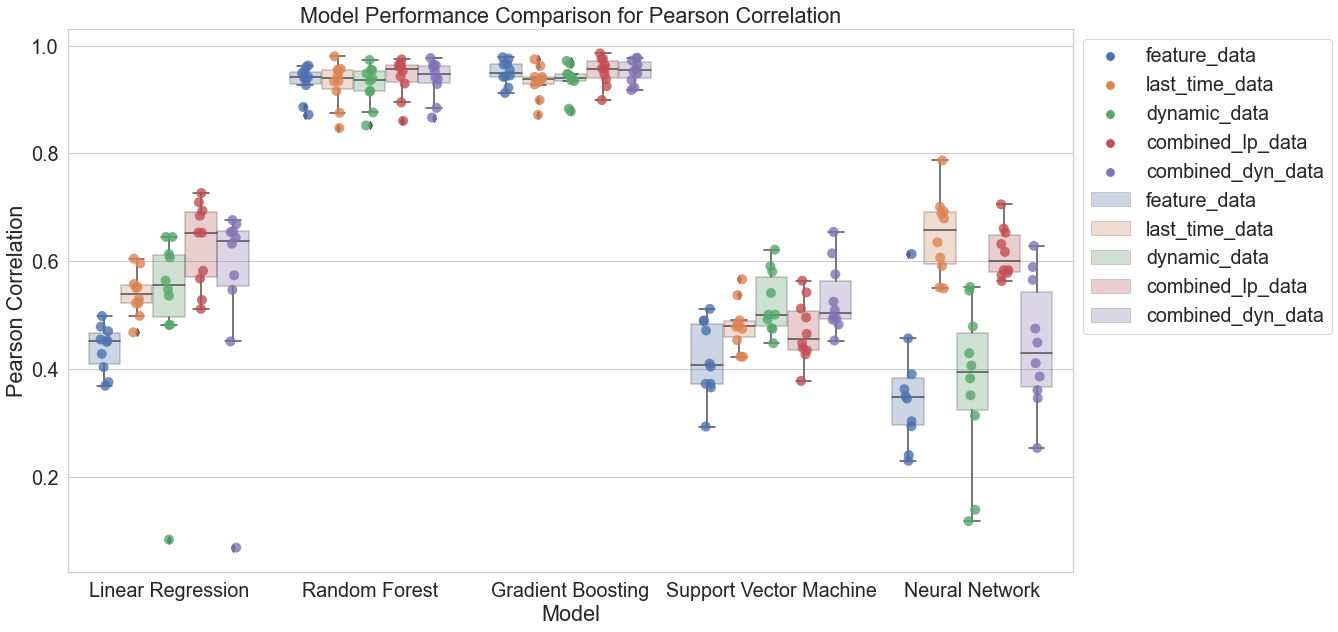

In [ ]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_13_model_performance_comparison_pearson.png')
plt.show()

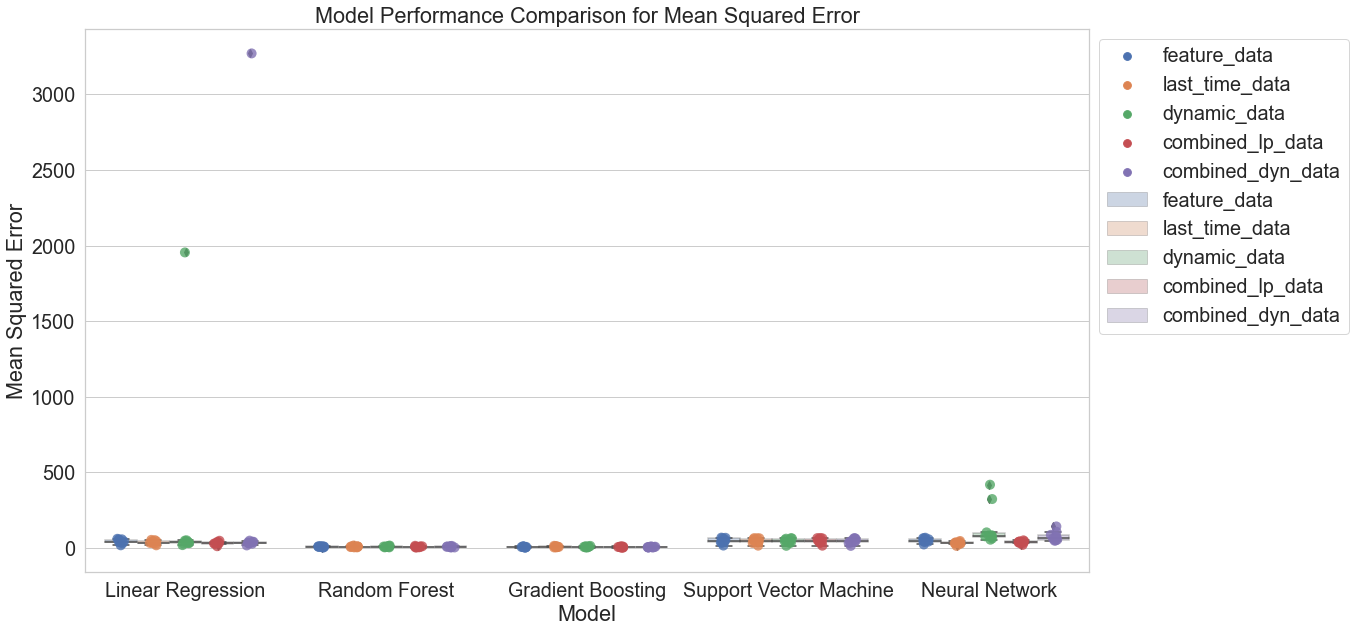

In [ ]:
# create box plots for each model type and feature data type, plot for pearson correlation

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Mean Squared Error', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Mean Squared Error')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

if save_figures:
    plt.savefig(experiment_folder + 'Fig_14A_all_model_performance_comparison_mse.png')
plt.show()